<h1><center> Santa-2020 - who's lucky? (leaderboard analysis) </center></h1>

<h2><center> <img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Xmasart_%2857%29.jpg" alt="Christmas img"></center></h2>

It's quite obvious that luck plays an important role in this competition. This notebook shows that most medal-winning teams have small number of "medal zone" agents. That is, these are lucky outliers (repeated submissions didn't achieve the same score). However, this effect is much smaller than in [Rock, Paper, Scissors](https://www.kaggle.com/demche/rock-paper-scissors-leaderboard-eda) competition.

[@dmitriyguller](https://www.kaggle.com/dmitriyguller) quite precisely formulated this issue: 
> The nature of the leaderboard also exaggerates luck, because it rewards the extreme deviation from expected performance, not the expected performance itself. An agent that scores 1100 99% of the time, but 1350 the other 1% of the time, is preferable to the agent who gets 1325 every single time.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from kaggle_environments import list_episodes
from IPython.display import display, Markdown
pd.set_option("display.max_rows", 200)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings('ignore')

Loading environment football failed: No module named 'gfootball'


In [2]:
!wget "https://www.kaggle.com/c/santa-2020/leaderboard.json?includeBeforeUser=true&includeAfterUser=false" -O leaderboard.json

--2021-03-02 15:53:31--  https://www.kaggle.com/c/santa-2020/leaderboard.json?includeBeforeUser=true&includeAfterUser=false
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘leaderboard.json’

leaderboard.json        [ <=>                ] 358.78K  --.-KB/s    in 0.1s    

2021-03-02 15:53:32 (2.66 MB/s) - ‘leaderboard.json’ saved [367387]



In [3]:
with open("leaderboard.json") as f:
    jsn = json.load(f)
leaderboard = pd.DataFrame(columns = ["team_name", "team_id", "score", "n_agents", "team_rank"])
for user in jsn["beforeUser"]+jsn["afterUser"]:
    leaderboard = leaderboard.append({"team_name": user["teamName"], 
                                      "team_id": user["teamId"], 
                                      "score": user["score"], 
                                      "n_agents": user["entries"],
                                     "team_rank": user["rank"]}, 
                                     ignore_index=True)
leaderboard[["score", "n_agents", "team_rank"]] = leaderboard[["score", "n_agents", "team_rank"]].apply(pd.to_numeric)
gold_min_score = leaderboard.sort_values("score", ascending=False)["score"][10]
silver_min_score = leaderboard.sort_values("score", ascending=False)["score"][49]
bronze_min_score = leaderboard.sort_values("score", ascending=False)["score"][99]

In [4]:
episodes = pd.read_csv("../input/meta-kaggle/Episodes.csv")
gaps = sorted(set(range(episodes[episodes["CompetitionId"] == 24539]["Id"].min(), episodes["Id"].max() + 1)) - set(episodes["Id"].values), reverse=True)
episodes = episodes.loc[episodes["CompetitionId"] == 24539]
episodes["CreateTime"] = pd.to_datetime(episodes["CreateTime"], format="%m/%d/%Y %H:%M:%S")
episodes = episodes[["Id", "CreateTime"]]

episode_agents = pd.read_csv("../input/meta-kaggle/EpisodeAgents.csv")
episode_agents = pd.merge(episode_agents, episodes, left_on="EpisodeId", right_on="Id")
episode_agents = episode_agents[["EpisodeId", "CreateTime", "SubmissionId", "UpdatedScore"]]
episode_agents = episode_agents.drop_duplicates()
episode_agents["date"] = episode_agents["CreateTime"].dt.date
agents_mapping = pd.DataFrame(columns = ["team_id", "submission_id", "submission_dt"])

episodes_to_consider = episode_agents[episode_agents["EpisodeId"].isin(episodes["Id"])].groupby(["SubmissionId"])["EpisodeId"].max().to_list()
for i in range(0, len(episodes_to_consider), 1000):
    batch = episodes_to_consider[i:i + 1000]
    try:
        resp = list_episodes(batch)  
        for episode in resp["result"]["submissions"]:
            agents_mapping = agents_mapping.append({"team_id": episode["teamId"],
                                "submission_id":  episode["id"] ,
                                "submission_dt": datetime.datetime.strptime(episode["dateSubmitted"][:19], "%Y-%m-%dT%H:%M:%S")
                               }, ignore_index=True)
        del episode, batch
    except Exception as ex:
        print("Error:", ex)
        continue

for i in range(0, len(gaps), 1000):
    batch = gaps[i:i + 1000]
    try:
        resp = list_episodes(batch)      
        if len(resp["result"]["episodes"]) != 0:
            for episode in resp["result"]["episodes"]:
                if episode["competitionId"] == 24539:
                    EpisodeId = episode["id"]
                    for agent in episode["agents"]:
                        submissionId = agent["submissionId"]
                        updatedScore = agent["updatedScore"]
                        CreateTime = datetime.strptime(episode["createTime"][:19], "%Y-%m-%dT%H:%M:%S")
                        episode_agents = episode_agents.append({"EpisodeId": EpisodeId,
                                                    "CreateTime": CreateTime,
                                                    "SubmissionId": submissionId,
                                                    "UpdatedScore": updatedScore
                                                    }, ignore_index=True)           
            for episode in episodes["result"]["submissions"]:
                agents_mapping = agents_mapping.append({"team_id": episode["teamId"],
                                    "submission_id":  episode["id"] ,
                                    "submission_dt": datetime.datetime.strptime(episode["dateSubmitted"][:19], "%Y-%m-%dT%H:%M:%S")
                                   }, ignore_index=True)
            del episode, batch
    except Exception as ex:
        print("Error:", ex)
        continue
        
agents_mapping = agents_mapping.drop_duplicates(subset=["submission_id"])
episode_agents = episode_agents[episode_agents["SubmissionId"].isin(agents_mapping["submission_id"])]
episode_agents = episode_agents.drop_duplicates()
agents = episode_agents.loc[episode_agents.groupby("SubmissionId").CreateTime.idxmax()].dropna(subset=["UpdatedScore"]).\
    loc[:, ["SubmissionId", "UpdatedScore"]].reset_index(drop=True)
agents.columns = ["submission_id", "score"]
agents = pd.merge(agents, agents_mapping, on="submission_id", how="left")
agents = agents.drop_duplicates(subset=["submission_id"])
agents = pd.merge(agents, leaderboard.loc[:, ["team_name", "team_id"]], on="team_id", how="left")
agents["medal"] = ["gold" if x >= gold_min_score else "silver" if x >= silver_min_score else "bronze" if x >= bronze_min_score else "no medal" \
     for x in agents["score"]]

Error: 'result'


# 1. Score distribution

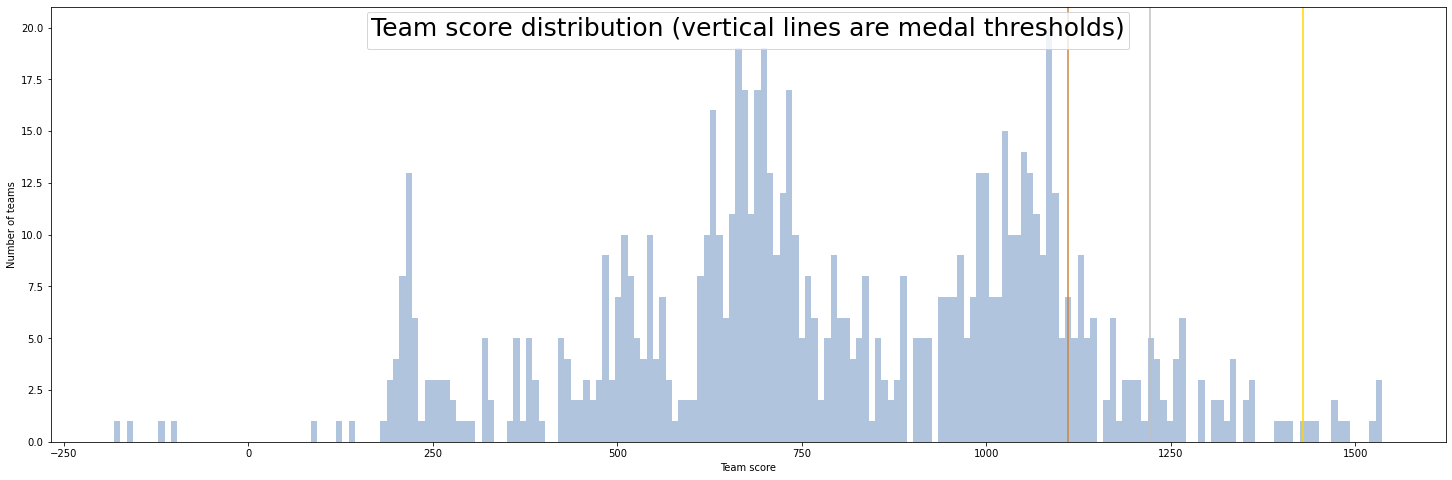

In [5]:
plt.figure(figsize=(25,8))
plt.hist(leaderboard["score"], color="lightsteelblue", bins=200)
plt.axvline(x=gold_min_score, color="gold")
plt.axvline(x=silver_min_score, color="silver")
plt.axvline(x=bronze_min_score, color="peru")
plt.xlabel("Team score")
plt.ylabel("Number of teams")
plt.legend(title="Team score distribution (vertical lines are medal thresholds)", loc="upper center", title_fontsize=25)
plt.show()

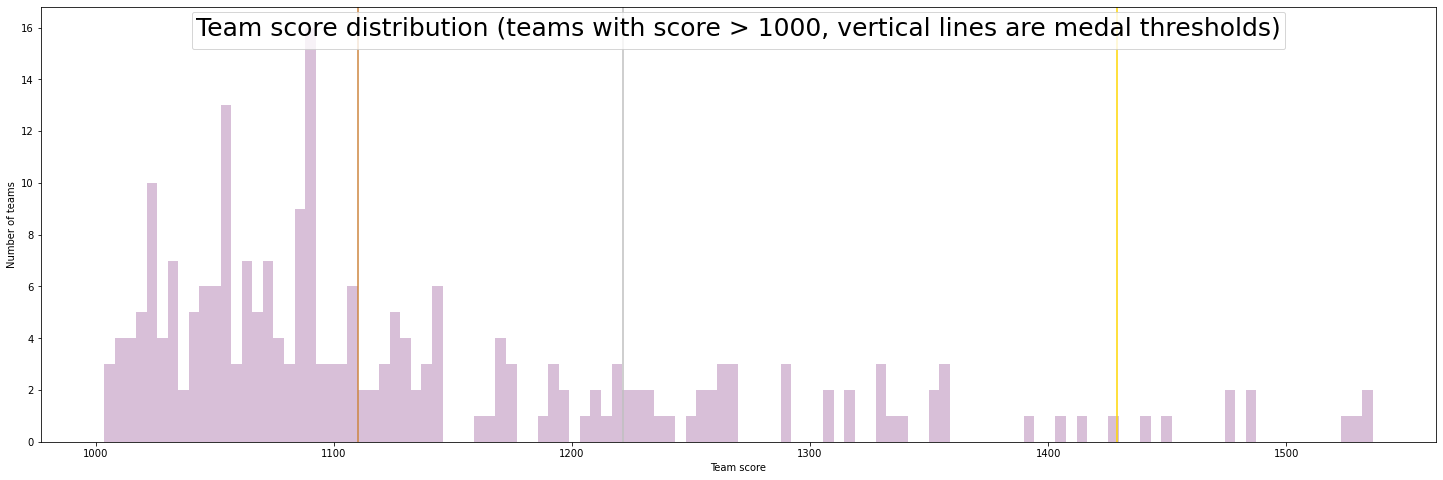

In [6]:
plt.figure(figsize=(25,8))
plt.hist(leaderboard["score"][leaderboard["score"] > 1000], color="thistle", bins=120)
plt.axvline(x=gold_min_score, color="gold")
plt.axvline(x=silver_min_score, color="silver")
plt.axvline(x=bronze_min_score, color="peru")
plt.xlabel("Team score")
plt.ylabel("Number of teams")
plt.legend(title="Team score distribution (teams with score > 1000, vertical lines are medal thresholds)", loc="upper center", title_fontsize=25)
plt.show()

In [7]:
leaderboard["score"].describe()

count     792.00
mean      794.70
std       300.04
min      -182.10
25%       624.40
50%       762.05
75%     1,038.15
max     1,536.20
Name: score, dtype: float64

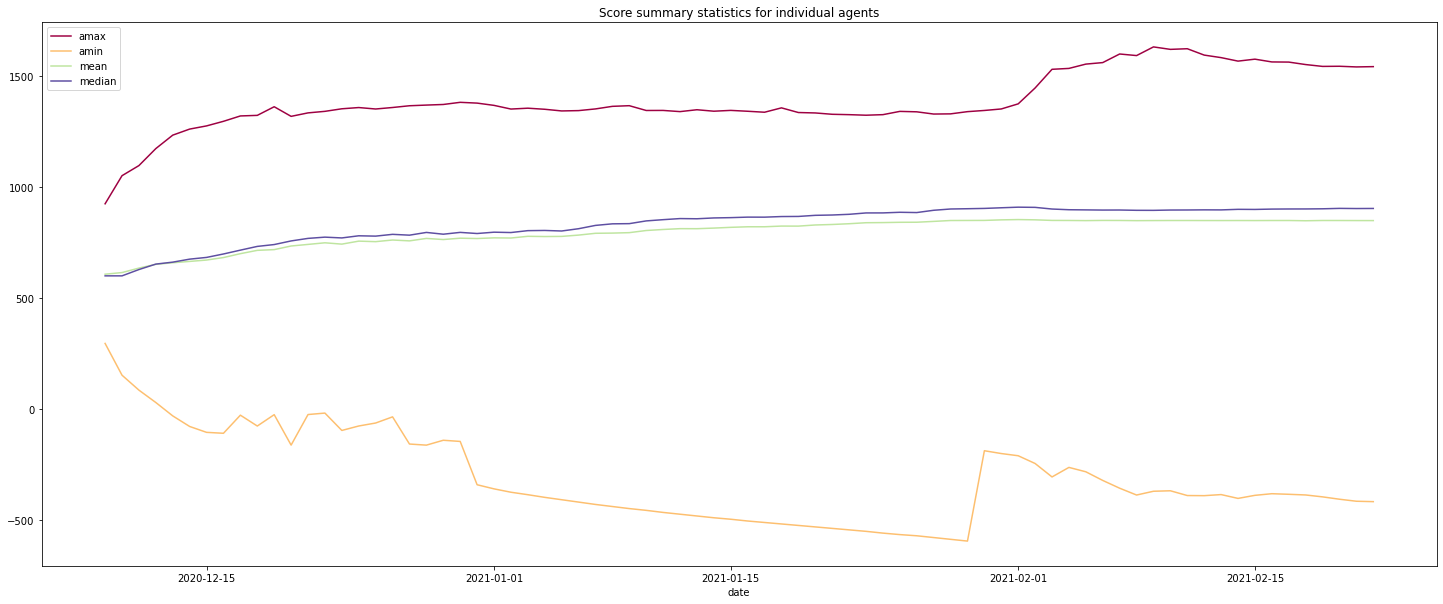

In [8]:
stat_santa = episode_agents.groupby(["date"]).agg({"UpdatedScore": [np.max, np.min, np.mean, np.median]}, axis="columns")
stat_santa.columns = stat_santa.columns.droplevel(0)
stat_santa.plot(figsize=(25,10), title="Score summary statistics for individual agents", colormap="Spectral")
plt.show()

# 2. Number of submissions for medal-winning teams

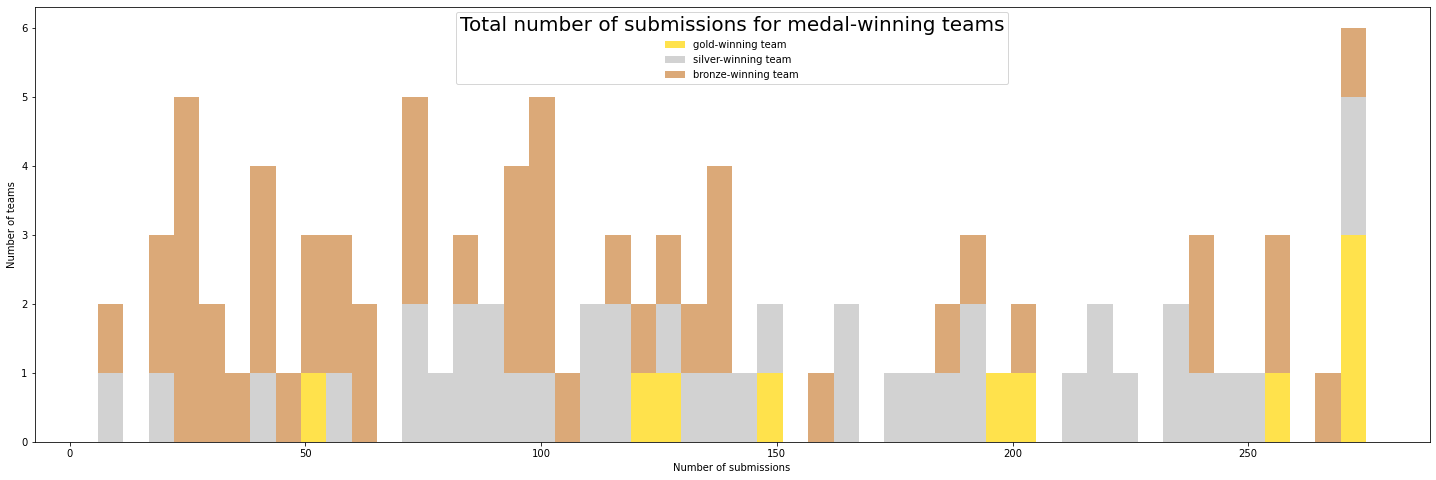

In [9]:
plt.figure(figsize=(25,8))
plt.hist([leaderboard.sort_values("score", ascending=False)["n_agents"][:10],
          leaderboard.sort_values("score", ascending=False)["n_agents"][11:51],
          leaderboard.sort_values("score", ascending=False)["n_agents"][51:101]],
         label=["gold-winning team", "silver-winning team", "bronze-winning team"],
         color= ["gold", "silver", "peru"], bins=50, stacked=True, alpha=0.7)
plt.xlabel("Number of submissions")
plt.ylabel("Number of teams")
plt.legend(title="Total number of submissions for medal-winning teams", loc="upper center", title_fontsize=20)
plt.show()

# 3. Medal zone agents

In [10]:
agents_bronze = agents[agents["medal"] == "bronze"].sort_values(by=["score"], ascending=False).reset_index()["team_name"].\
value_counts().reset_index().rename(columns={"index": "team", "team_name": "bronze"})
agents_silver = agents[agents["medal"] == "silver"].sort_values(by=["score"], ascending=False).reset_index()["team_name"].\
value_counts().reset_index().rename(columns={"index": "team", "team_name": "silver"})
agents_gold = agents[agents["medal"] == "gold"].sort_values(by=["score"], ascending=False).reset_index()["team_name"].\
value_counts().reset_index().rename(columns={"index": "team", "team_name": "gold"})
medal_zone_agents = pd.merge(pd.merge(agents_gold, agents_silver, on="team", how="outer"), agents_bronze, on="team", how="outer").fillna(0)
medal_zone_agents["bronze"] = medal_zone_agents["bronze"].astype(int)
medal_zone_agents["silver"] = medal_zone_agents["silver"].astype(int)
medal_zone_agents["gold"] = medal_zone_agents["gold"].astype(int)
medal_zone_agents.head(100).style.background_gradient(cmap="YlGn")

,team,gold,silver,bronze
0,Coffee Candy ☕,17,83,19
1,kibuna,9,112,7
2,Dmitriy Guller,7,73,34
3,toshi_k,5,107,10
4,woody285,3,92,17
5,nagiss 🦌,3,196,25
6,Kun Hao Yeh,2,58,65
7,(⊙﹏⊙),2,44,28
8,skneko,1,22,73
9,TBD,1,37,8


# 4. Time of submission by medal zone

[@pedram](https://www.kaggle.com/pedram) [suggested](https://www.kaggle.com/c/santa-2020/discussion/214271) that newly written agents can possibly get into the top. Right now there is no apparent relationship between submission time and score. 

Medal: bronze

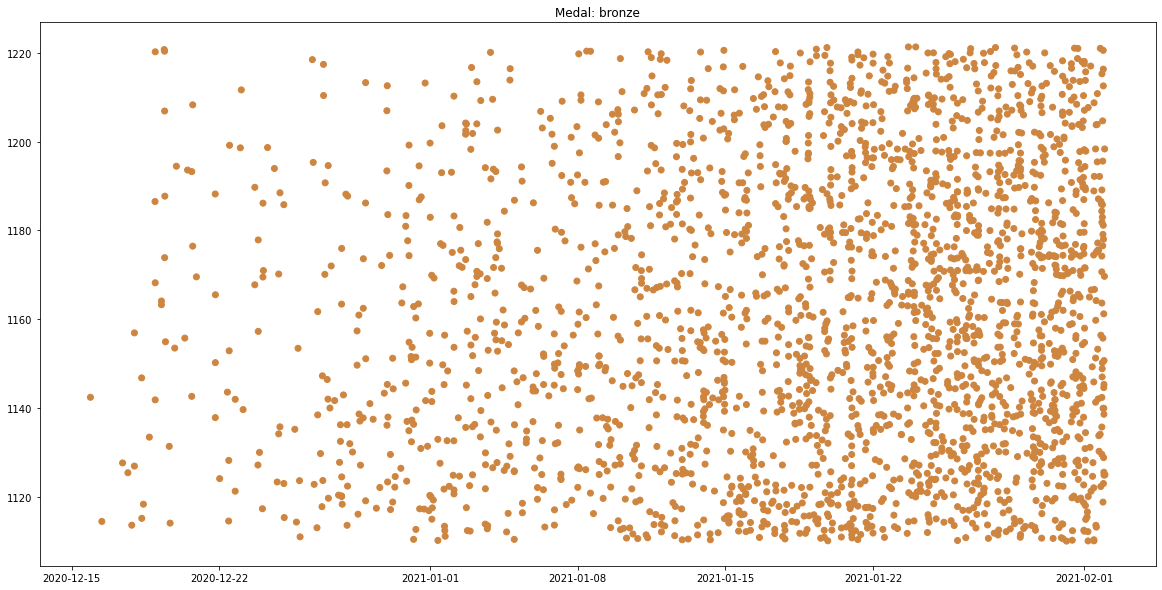

Medal: gold

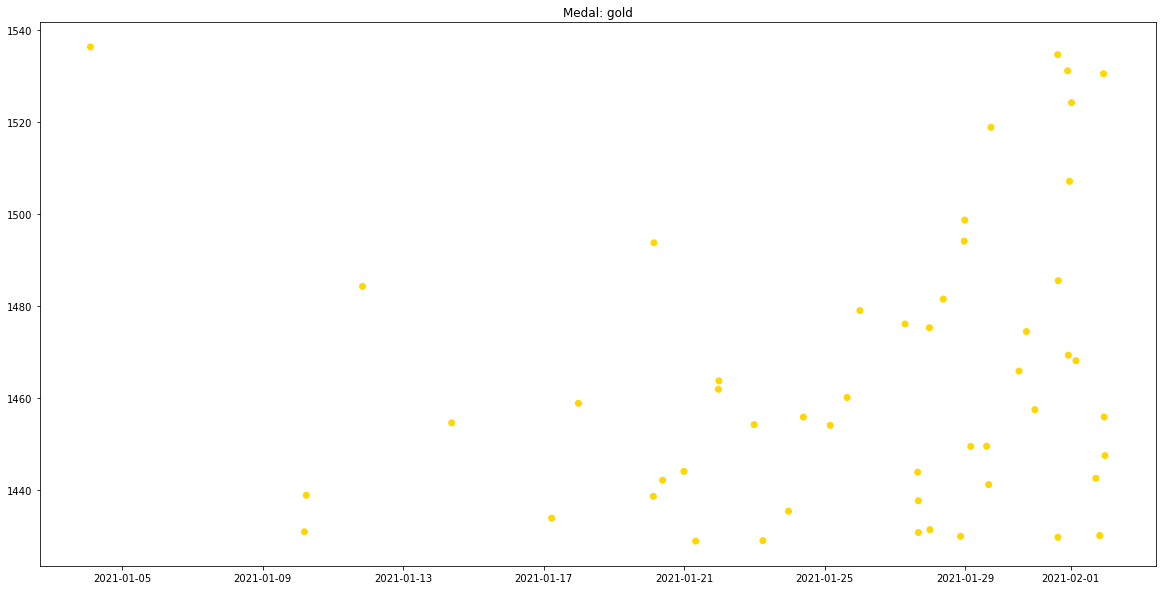

Medal: no medal

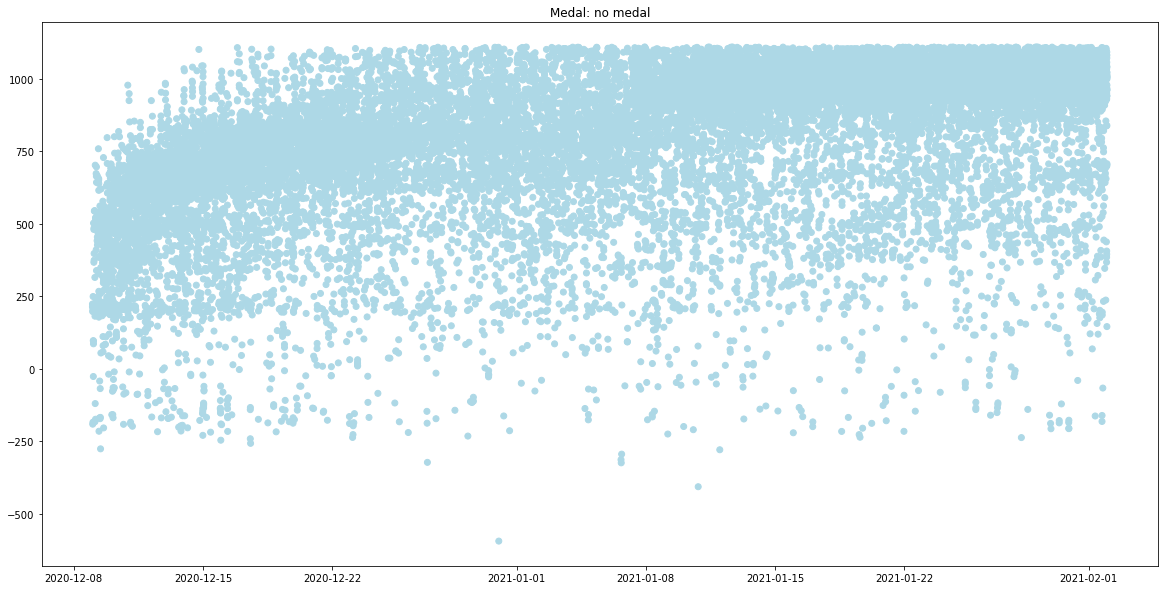

Medal: silver

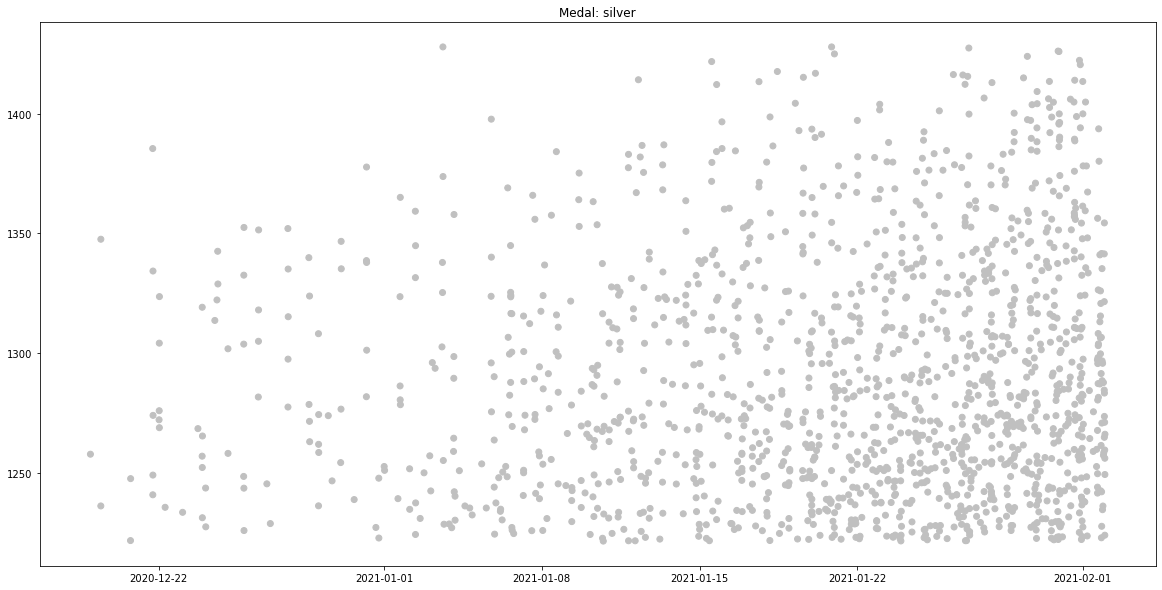

In [11]:
agents["medal_color"] = ["peru" if x == "bronze" else "lightblue" if x == "no medal" else x for x in agents["medal"]]
for medal_type, group in agents.groupby("medal"):
    display(Markdown("Medal: " + str(medal_type)))
    plt.figure(figsize=(20, 10))
    plt.scatter(group["submission_dt"], group["score"], c=group["medal_color"])
    plt.title("Medal: " + str(medal_type))
    plt.show()

# 5. Top-10 agents for medal-winning teams

In [12]:
top_teams_agents = agents[agents["team_id"].isin(leaderboard.sort_values(by=["score"], ascending=False).head(100)["team_id"])].reset_index()
top_teams_agents = pd.merge(top_teams_agents, leaderboard[["team_id", "team_rank"]], on=["team_id"], how="left")

In [13]:
top_teams_agents_best10 = top_teams_agents.sort_values("score",ascending = False).groupby("team_id").head(10).reset_index(drop=True)
top_teams_agents_best10 = top_teams_agents_best10.loc[:, ["team_name", "score"]]
top_teams_agents_best10["rank"] = top_teams_agents_best10.groupby("team_name")["score"].rank("dense", ascending=False).astype(int)
top_teams_agents_best10.pivot(index="team_name", columns="rank", values="score").sort_values(1,ascending = False).style.background_gradient(cmap="YlOrBr")

rank,1,2,3,4,5,6,7,8,9,10
team_name,,,,,,,,,,
nagiss 🦌,1536.230375,1454.070114,1429.018558,1427.955447,1416.935249,1416.229804,1413.431489,1397.765413,1385.475628,1384.506289
kibuna,1534.560305,1481.470821,1468.099915,1465.844731,1454.602884,1449.543861,1443.888672,1437.692179,1429.752888,1424.005778
Coffee Candy ☕,1531.043722,1530.402410,1507.062481,1498.644611,1494.050727,1478.976325,1475.253866,1469.300559,1463.711633,1461.897873
Dmitriy Guller,1524.116222,1518.773179,1493.687147,1460.105620,1457.466598,1438.650570,1429.982581,1414.030969,1413.515089,1403.800260
(⊙﹏⊙),1485.475111,1455.858556,1404.912386,1404.850345,1397.246474,1383.094908,1372.684774,1370.268987,1367.615516,1355.856006
woody285,1484.237212,1442.563188,1430.795455,1427.958269,1412.324804,1412.231262,1398.865745,1398.638829,1392.119528,1388.685351
Xrc,1476.068167,1348.174961,1335.768373,1324.198390,1323.316698,1316.702916,1315.599859,1312.293965,1310.808627,1303.828455
TBD,1474.430464,1426.024175,1420.525028,1415.638086,1396.128474,1386.274979,1382.357406,1370.366012,1354.395778,1347.395355
toshi_k,1449.491743,1442.147674,1438.881115,1433.920562,1430.951881,1417.670690,1416.404847,1415.019267,1406.278582,1404.402354


# 6. Best agent vs top agents

Best agent is clearly outlier if there is significant difference between its score and top agents' score.

In [14]:
best1_agents = agents.sort_values("score",ascending = False).groupby("team_name").head(1).reset_index(drop=True).\
    groupby("team_name").agg({"score": np.mean}).rename(columns={"score": "best agent"})
best10_agents = agents.sort_values("score",ascending = False).groupby("team_name").head(10).reset_index(drop=True).\
    groupby("team_name").agg({"score": np.mean}).rename(columns={"score": "top 10 agents"})
best30_agents = agents.sort_values("score",ascending = False).groupby("team_name").head(30).reset_index(drop=True).\
    groupby("team_name").agg({"score": np.mean}).rename(columns={"score": "top 30 agents"})
best_agents = pd.merge(pd.merge(pd.merge(best1_agents, best10_agents, on=["team_name"]), best30_agents, on=["team_name"]), 
                leaderboard.loc[:, ["team_name", "n_agents"]], on=["team_name"])
best_agents["difference best - top 10"] = best_agents.apply(lambda x: x["best agent"] - x["top 10 agents"], axis=1)
best_agents["difference best - top 30"] = best_agents.apply(lambda x: x["best agent"] - x["top 30 agents"], axis=1)
best_agents["medal"] = ["gold" if x >= gold_min_score else "silver" if x >= silver_min_score else "peru" if x >= bronze_min_score else "lightblue" \
     for x in best_agents["best agent"]]

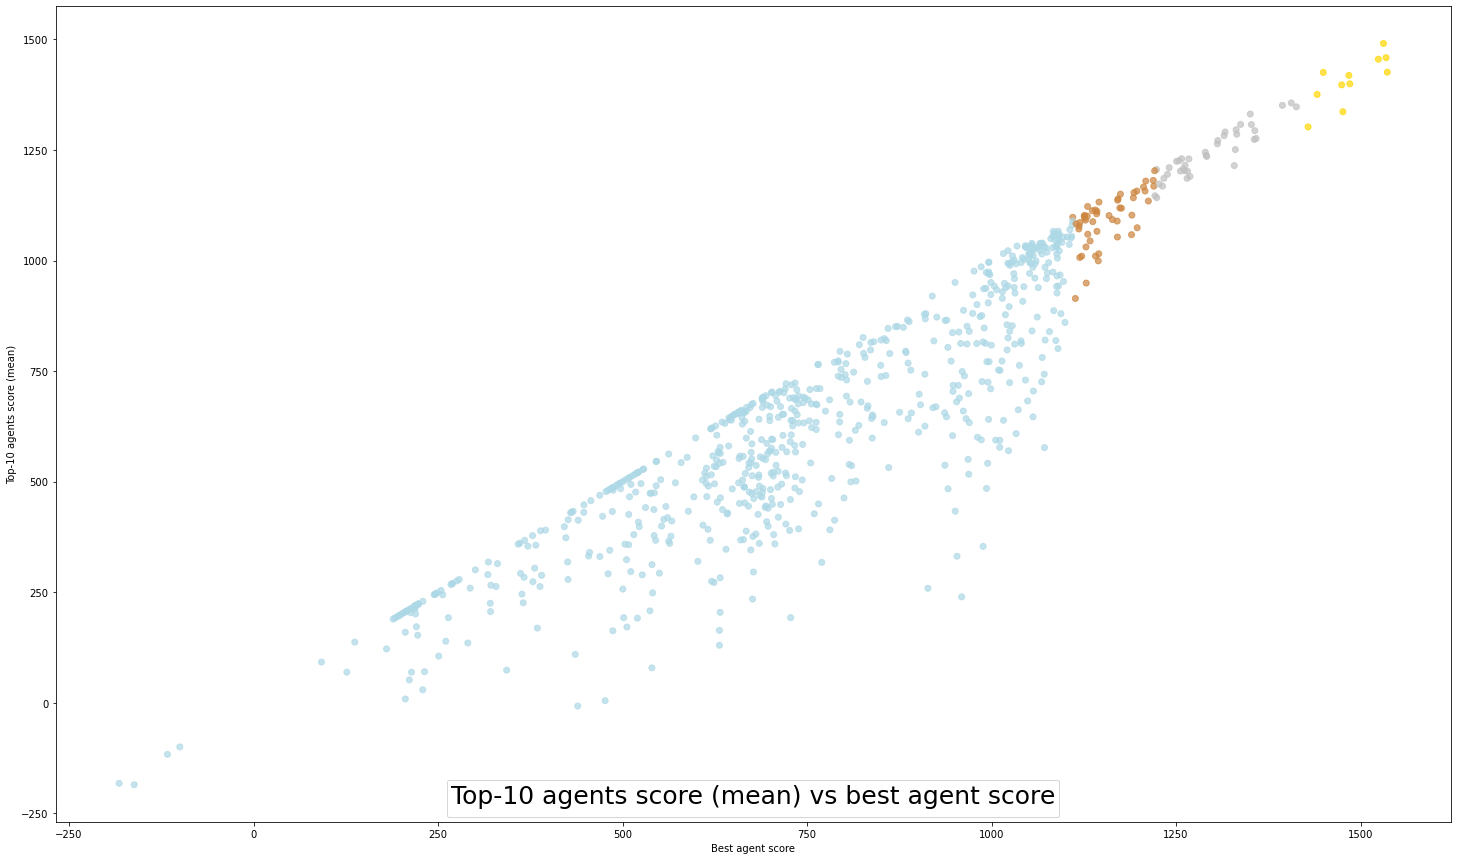

In [15]:
plt.figure(figsize=(25,15))
plt.scatter(best_agents["best agent"], best_agents["top 10 agents"], c=best_agents["medal"], alpha=0.7)
plt.xlabel("Best agent score")
plt.ylabel("Top-10 agents score (mean)")
plt.legend(title="Top-10 agents score (mean) vs best agent score", loc="lower center", title_fontsize=25)
plt.show()

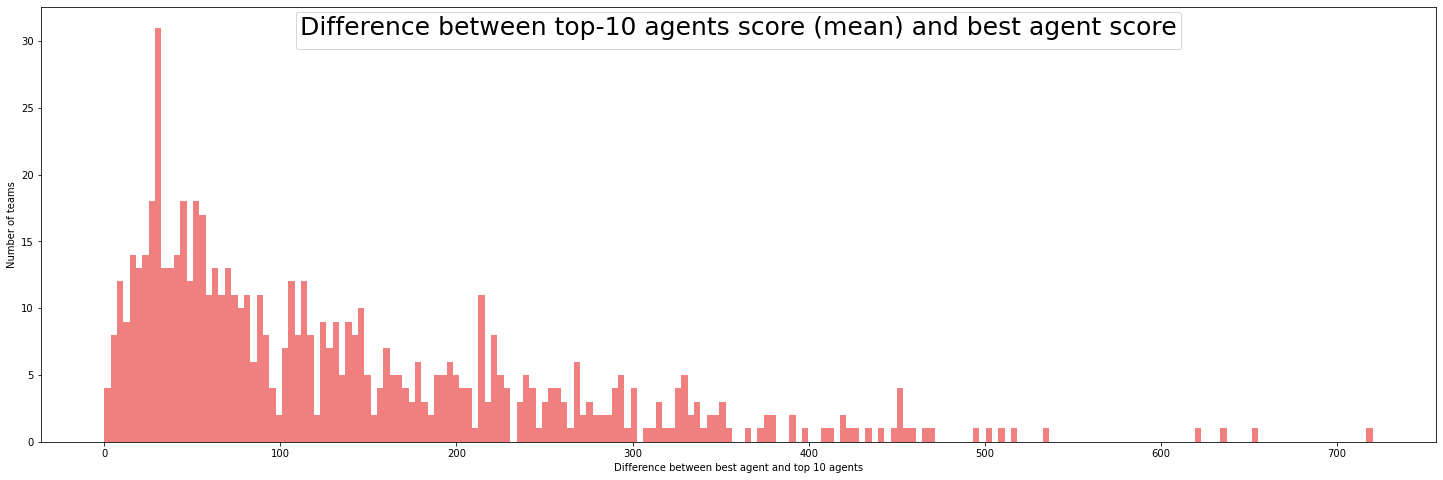

In [16]:
plt.figure(figsize=(25,8))
plt.hist(best_agents["difference best - top 10"][best_agents["difference best - top 10"] != 0], color="lightcoral", bins=200)
plt.xlabel("Difference between best agent and top 10 agents")
plt.ylabel("Number of teams")
plt.legend(title="Difference between top-10 agents score (mean) and best agent score", loc="upper center", title_fontsize=25)
plt.show()

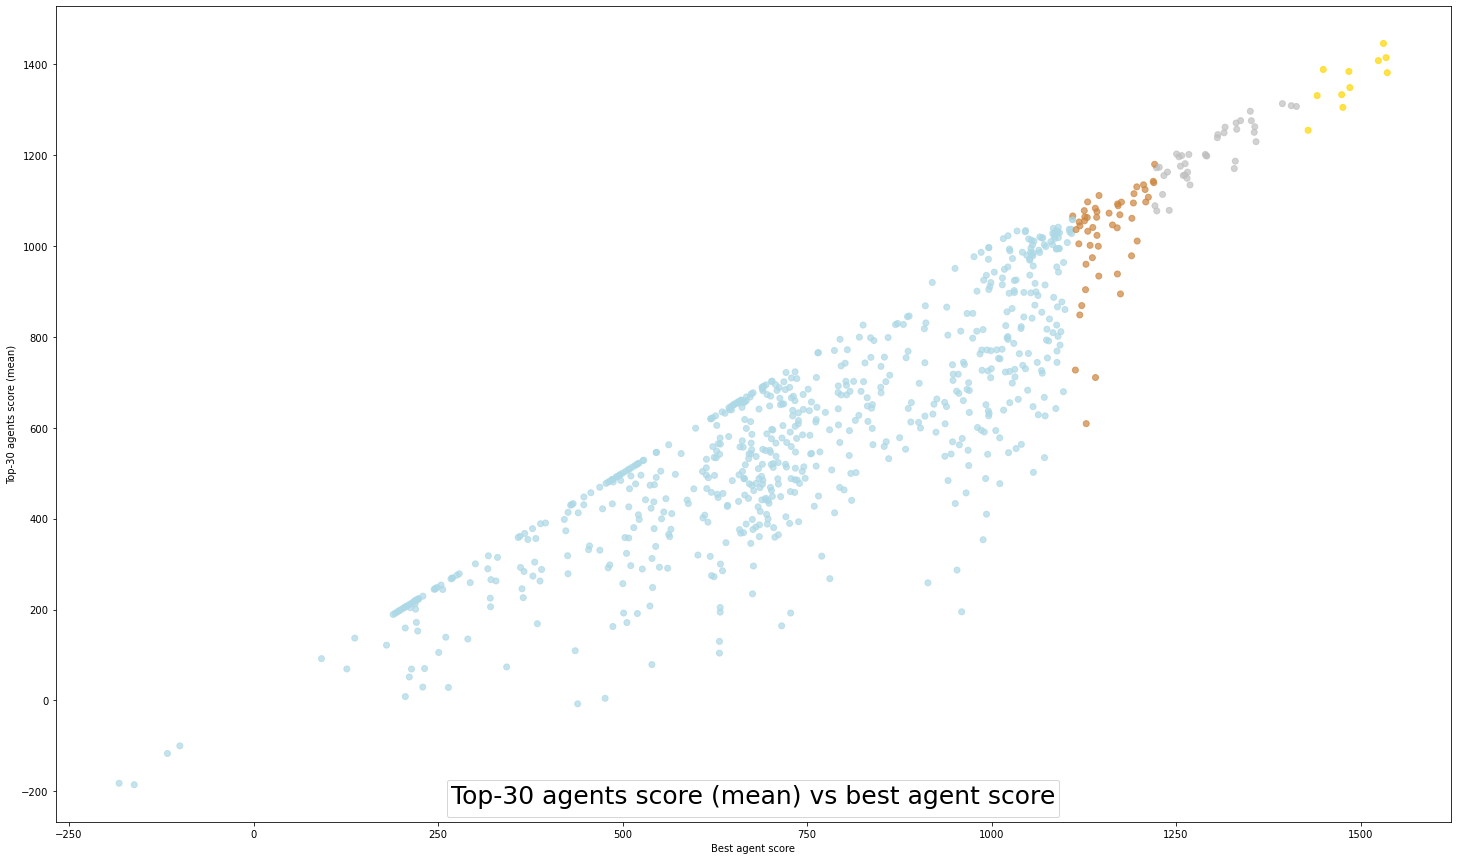

In [17]:
plt.figure(figsize=(25,15))
plt.scatter(best_agents["best agent"], best_agents["top 30 agents"], c=best_agents["medal"], alpha=0.7)
plt.xlabel("Best agent score")
plt.ylabel("Top-30 agents score (mean)")
plt.legend(title="Top-30 agents score (mean) vs best agent score", loc="lower center", title_fontsize=25)
plt.show()

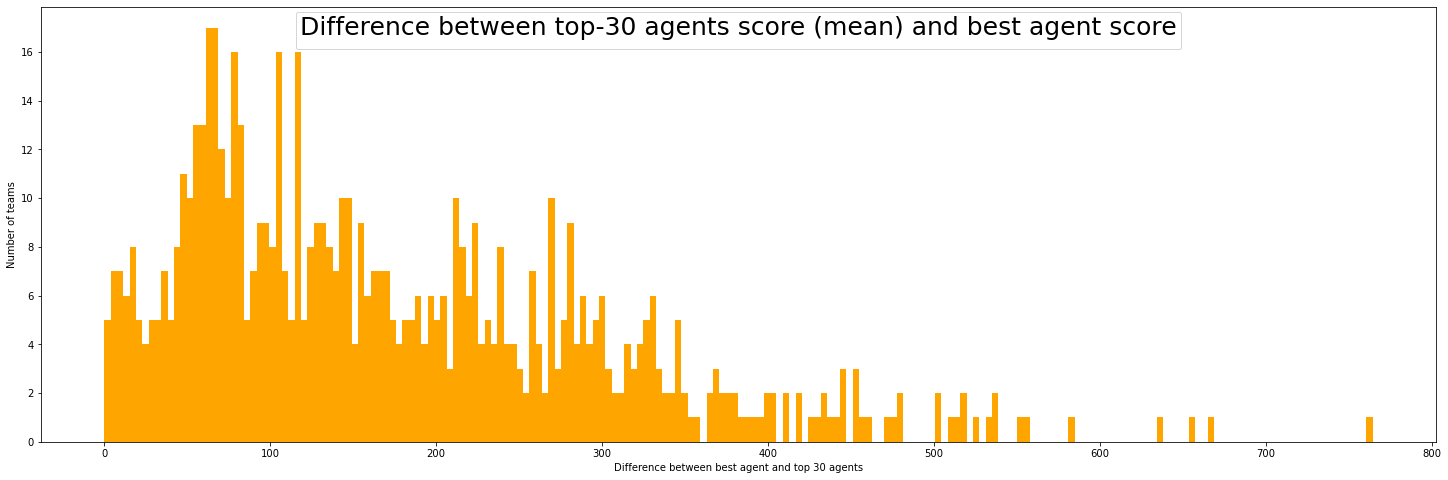

In [18]:
plt.figure(figsize=(25,8))
plt.hist(best_agents["difference best - top 30"][best_agents["difference best - top 30"] != 0], color="orange", bins=200)
plt.xlabel("Difference between best agent and top 30 agents")
plt.ylabel("Number of teams")
plt.legend(title="Difference between top-30 agents score (mean) and best agent score", loc="upper center", title_fontsize=25)
plt.show()

Difference for medal-winning teams:

In [19]:
best_agents[best_agents["team_name"].isin(leaderboard.sort_values("score", ascending=False)["team_name"][0:99])].\
    loc[:, ["team_name", "best agent", "top 10 agents", "top 30 agents", "difference best - top 10", 
             "difference best - top 30", "n_agents"]].sort_values("best agent", ascending=False).reset_index(drop=True)

,team_name,best agent,top 10 agents,top 30 agents,difference best - top 10,difference best - top 30,n_agents
0,nagiss 🦌,"1,536.23","1,426.16","1,381.16",110.07,155.07,275
1,kibuna,"1,534.56","1,458.95","1,414.23",75.61,120.33,198
2,Coffee Candy ☕,"1,531.04","1,491.03","1,445.45",40.01,85.60,129
3,Dmitriy Guller,"1,524.12","1,455.41","1,407.67",68.70,116.44,200
4,(⊙﹏⊙),"1,485.48","1,399.79","1,348.36",85.69,137.11,274
5,woody285,"1,484.24","1,418.84","1,383.80",65.40,100.43,124
6,Xrc,"1,476.07","1,336.68","1,304.79",139.39,171.28,256
7,TBD,"1,474.43","1,397.35","1,332.86",77.08,141.57,51
8,toshi_k,"1,449.49","1,425.52","1,388.16",23.97,61.33,275
9,Kun Hao Yeh,"1,441.20","1,375.80","1,330.69",65.40,110.51,149
